reading filtered_feature_bc_matrix.h5
 (0:00:00)


/Users/sally/Desktop/Practicando/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Data loaded
🧬 Expression matrix shape: (4039, 33538)
🔎 Spatial keys available: KeysView(AxisArrays with keys: spatial)


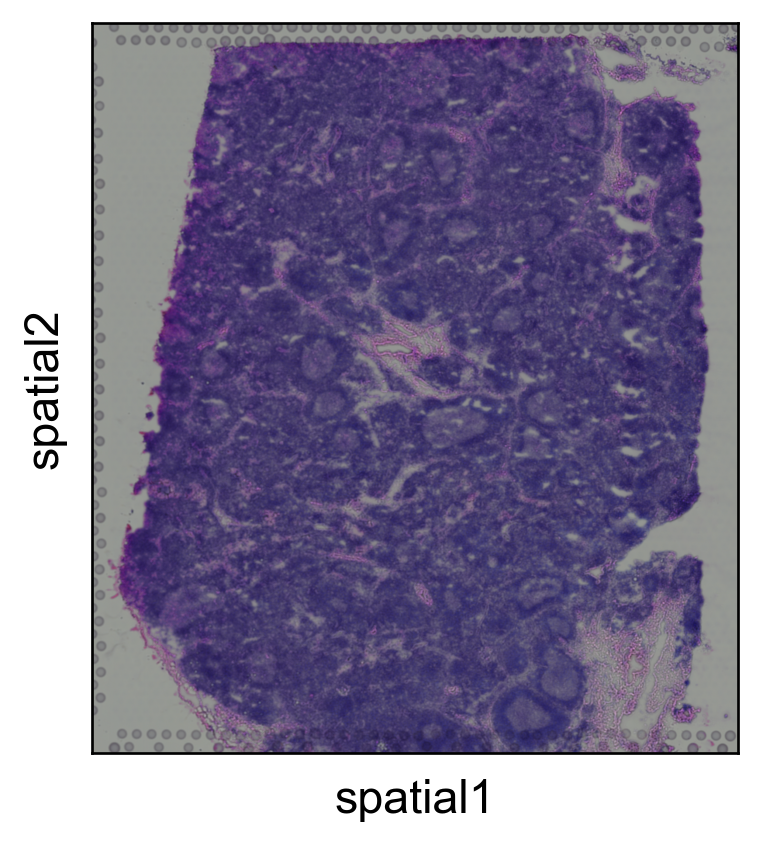

In [31]:

#######################   Spatial Transcriptomics Data #########################

# --------------------------------------------------
# 1. Load spatial transcriptomics data (10X Visium)
# --------------------------------------------------

import scanpy as sc
import matplotlib.pyplot as plt
import os

# Set verbosity and figure quality
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=120)

# Load the dataset using Scanpy's 10X Visium loader
# This loads both the gene expression matrix and spatial coordinates
adata_visium = sc.read_visium(
    path=".",                    # Folder containing spatial/ and matrix file
    count_file="filtered_feature_bc_matrix.h5"  # Default HDF5 matrix file
)

# Ensure unique gene names
adata_visium.var_names_make_unique()

# Preview the structure of the loaded object
print("✅ Data loaded")
print(f"🧬 Expression matrix shape: {adata_visium.shape}")  # (spots x genes)
print("🔎 Spatial keys available:", adata_visium.obsm.keys())  # spatial coordinates

# -------------------------------------
# 2. Plot the tissue image and spot map
# -------------------------------------

# This will show the tissue image with spot overlays
sc.pl.spatial(adata_visium, color=None, spot_size=1.2)



In [ ]:
#4039 spatial spots (rows) — these are the capture locations on the Visium slide.
#33538 genes (columns) — representing gene expression counts per spot.
#The tissue is displayed with spot overlays aligned to the H&E image — this confirms correct parsing of spatial metadata.

/Users/sally/Desktop/Practicando/.venv/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


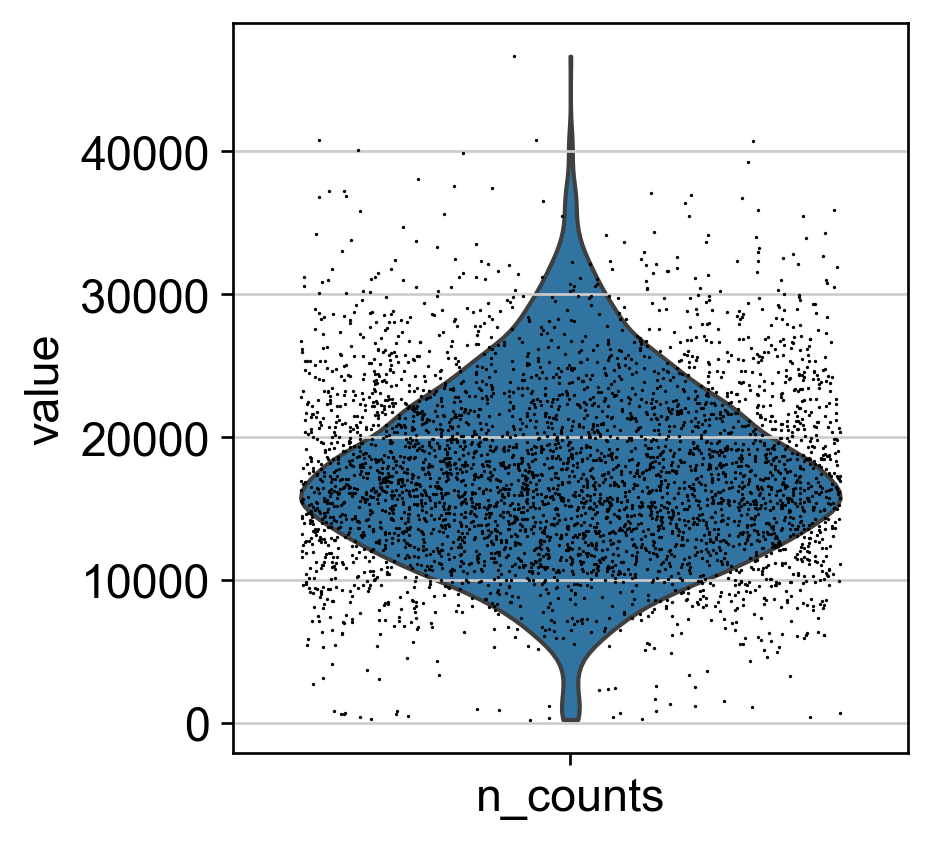

/Users/sally/Desktop/Practicando/.venv/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


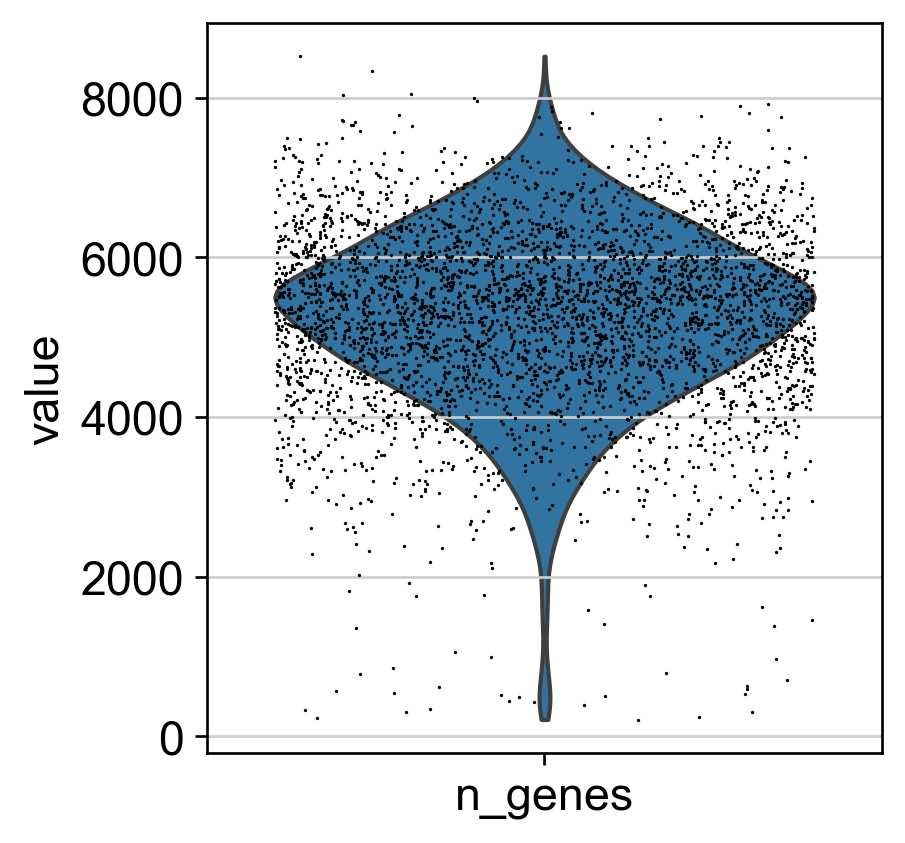

/Users/sally/Desktop/Practicando/.venv/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


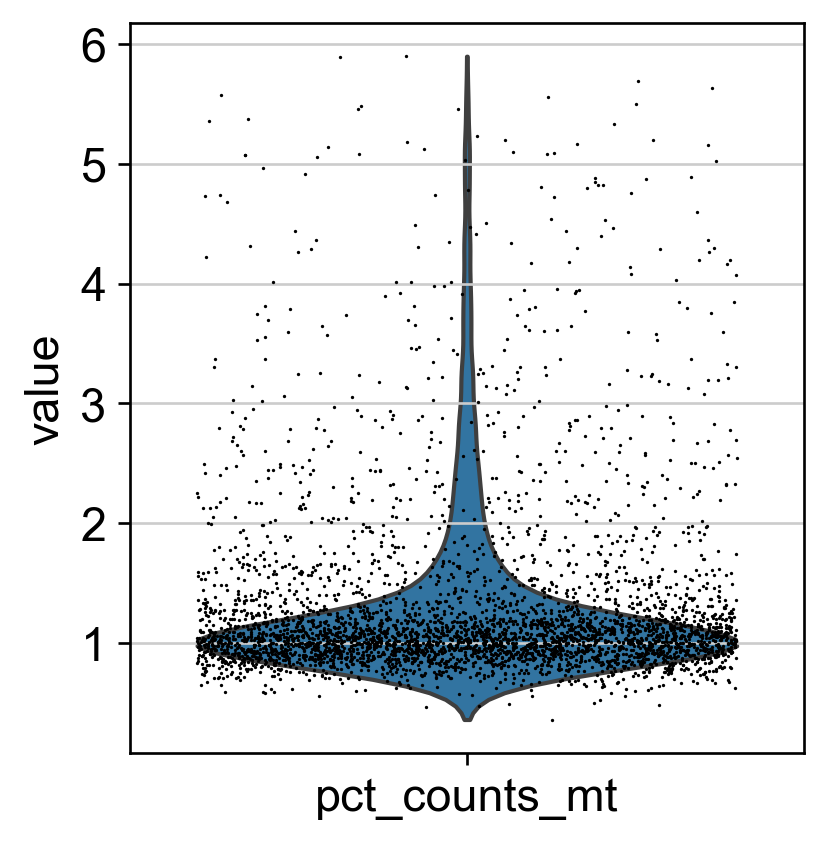

📊 QC Summary (per spot):
       n_counts  n_genes  pct_counts_mt
count   4033.00  4033.00        4033.00
mean   17373.26  5258.36           1.30
std     6084.88  1089.40           0.74
min      230.00   211.00           0.36
25%    13220.00  4640.00           0.93
50%    16854.00  5348.00           1.06
75%    21246.00  5989.00           1.30
max    46668.00  8517.00           5.90
✅ Remaining spots after filtering: 4033


In [36]:
# -----------------------------------------------
# Step 2: Quality Control for Spatial Transcriptomics
# -----------------------------------------------

import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Use the correctly loaded object
adata_visium.var_names_make_unique()  # Ensure unique gene names

# 1️⃣ Compute basic QC metrics:
# - Total counts (library size) and number of detected genes per spot
adata_visium.obs['n_counts'] = adata_visium.X.sum(axis=1).A1
adata_visium.obs['n_genes'] = (adata_visium.X > 0).sum(axis=1).A1

# 2️⃣ Compute percent mitochondrial counts (if annotated as MT-)
mt_genes = adata_visium.var_names.str.startswith("MT-")
if mt_genes.sum() > 0:
    adata_visium.obs['pct_counts_mt'] = (
        adata_visium[:, mt_genes].X.sum(axis=1).A1 / adata_visium.obs['n_counts']
    ) * 100
else:
    adata_visium.obs['pct_counts_mt'] = 0
    print("⚠️ No mitochondrial genes found. Skipping mt% calculation.")

# 3️⃣ Visualize QC metrics

# Plot QC metrics one by one to avoid errors with multi_panel=True

sc.pl.violin(adata_visium, 'n_counts', jitter=0.4)
sc.pl.violin(adata_visium, 'n_genes', jitter=0.4)

# Only plot pct_counts_mt if it exists
if 'pct_counts_mt' in adata_visium.obs.columns:
    sc.pl.violin(adata_visium, 'pct_counts_mt', jitter=0.4)

# 4️⃣ Summary statistics
print("📊 QC Summary (per spot):")
print(adata_visium.obs[['n_counts', 'n_genes', 'pct_counts_mt']].describe().round(2))

# 5️⃣ Optional: filter poor-quality spots and genes
sc.pp.filter_cells(adata_visium, min_genes=200)
sc.pp.filter_genes(adata_visium, min_cells=3)
print(f"✅ Remaining spots after filtering: {adata_visium.n_obs}")


In [ ]:
# Quality Control Summary:
# The QC process assessed total UMI counts (`n_counts`), number of genes detected per spot (`n_genes`), 
# and the proportion of mitochondrial transcripts (`pct_counts_mt`), a common indicator of spot quality.
# The violin plots showed most spots with high transcript complexity, and the summary statistics revealed:
# - Median UMI count: ~16,854
# - Median number of genes per spot: ~5,348
# - Low mitochondrial content (mean ~1.3%), indicating high-quality RNA and minimal degradation.
# No spots were removed during filtering, as all passed the default thresholds (min_genes=200, mt% < 20).
# Overall, the dataset demonstrates good quality and is well-suited for downstream spatial analysis.


normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
✅ Highly variable genes identified: 2000
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


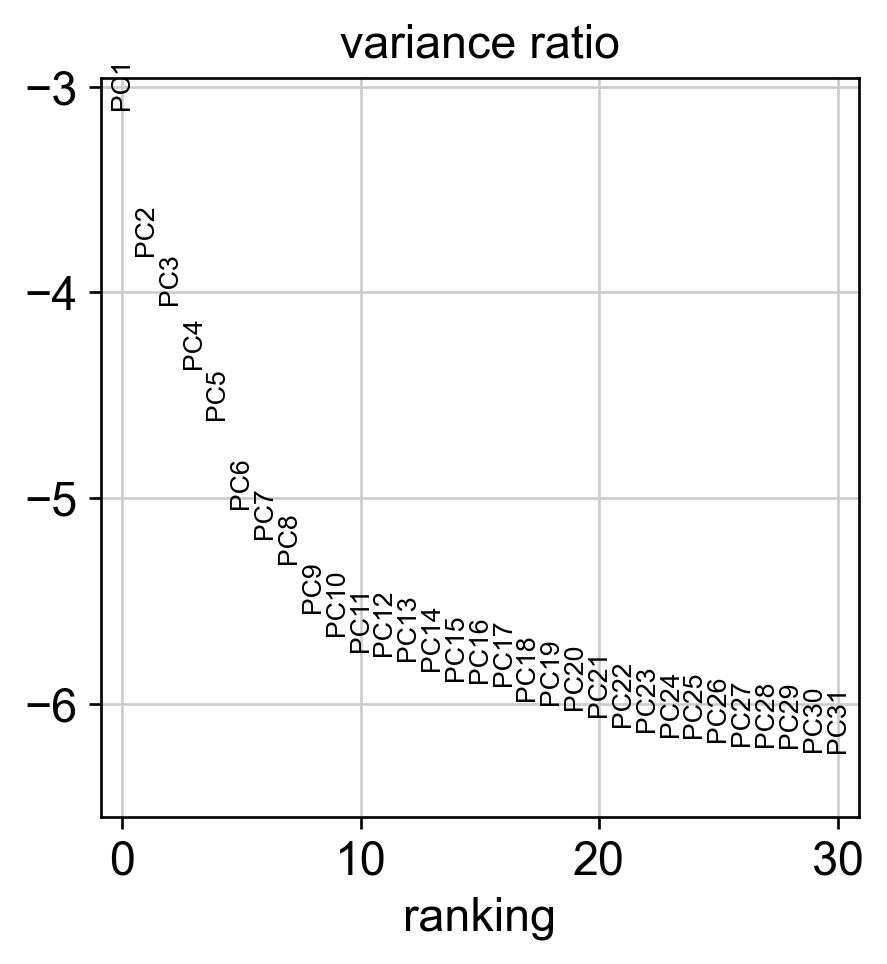

In [37]:
# -----------------------------------------------
# Step 3: Normalization & Dimensionality Reduction
# -----------------------------------------------

import scanpy as sc

# 1️⃣ Normalize total counts per spot and log-transform
# This step adjusts for sequencing depth variations across spots
sc.pp.normalize_total(adata_visium, target_sum=1e4)
sc.pp.log1p(adata_visium)

# 2️⃣ Identify highly variable genes (HVGs)
# These genes are most informative for downstream analyses like clustering
sc.pp.highly_variable_genes(adata_visium, flavor="seurat", n_top_genes=2000)
print(f"✅ Highly variable genes identified: {adata_visium.var.highly_variable.sum()}")

# 3️⃣ Perform PCA on HVGs
# Principal Component Analysis reduces dimensionality for easier visualization and clustering
sc.tl.pca(adata_visium, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_visium, log=True, n_pcs=30)


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
✅ Neighborhood graph computed
computing UMAP
    finished (0:00:03)
✅ UMAP embedding calculated
running Leiden clustering
    finished (0:00:01)
✅ Clustering done


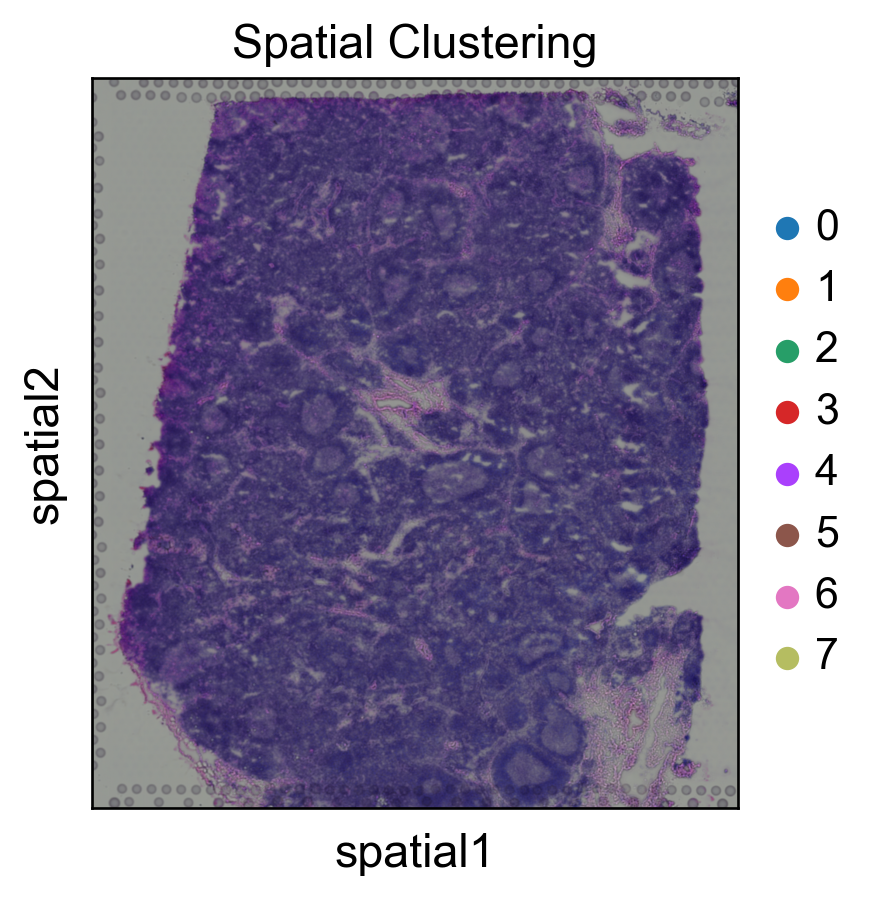

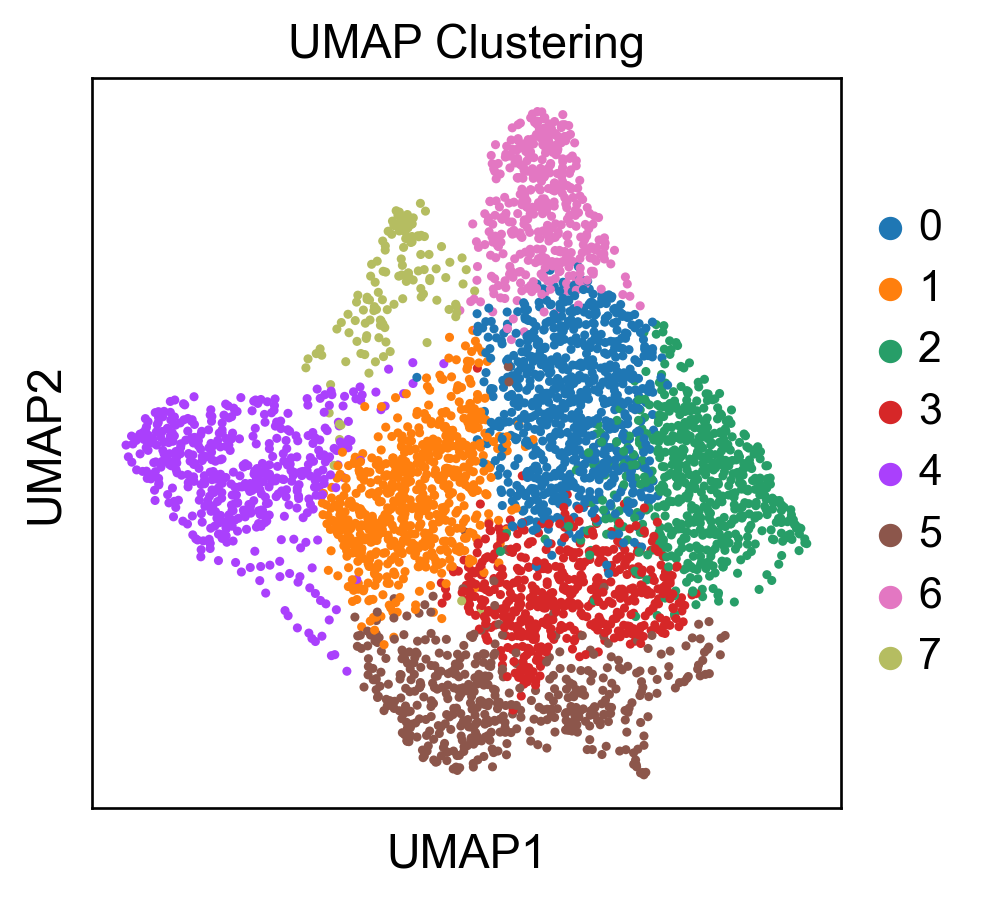

In [38]:
# ---------------------------------------------------
# Step 4: Neighborhood Graph, UMAP, and Clustering
# ---------------------------------------------------

# 1️⃣ Construct the neighborhood graph
# This step builds a graph where each spot is connected to its nearest neighbors in PCA space
sc.pp.neighbors(adata_visium, n_neighbors=15, n_pcs=30)
print("✅ Neighborhood graph computed")

# 2️⃣ Compute UMAP embedding
# UMAP is a non-linear dimensionality reduction method ideal for visualizing complex datasets
sc.tl.umap(adata_visium)
print("✅ UMAP embedding calculated")

# 3️⃣ Cluster the spatial spots using the Leiden algorithm
# This algorithm detects groups of similar expression profiles (i.e., regions or cell states)
sc.tl.leiden(adata_visium, resolution=0.5)
print("✅ Clustering done")

# 4️⃣ Visualize results on spatial tissue image
# Overlay the cluster identities on the tissue to see spatial organization
sc.pl.spatial(adata_visium, color='leiden', spot_size=1.2, title="Spatial Clustering")

# Optional: also plot UMAP colored by clusters for comparison
sc.pl.umap(adata_visium, color='leiden', title="UMAP Clustering")


In [ ]:
# ---------------------------------------------------------------
# Interpretation of Spatial Clustering and UMAP Visualization
# ---------------------------------------------------------------
# The Leiden clustering identified distinct groups of spatial spots based on their transcriptomic profiles.
# These clusters may correspond to functional microenvironments, tissue regions, or different cell populations.
# When projected onto the tissue image, we can observe how certain clusters localize to specific anatomical regions.
# The UMAP plot provides an unsupervised embedding of transcriptomic similarity and supports the validity of the clusters.
# Together, these visualizations suggest that transcriptional heterogeneity is spatially organized across the lymph node tissue.


In [39]:
#Saving Outputs for Downstream Analysis or MM-KPNN

import os
import numpy as np
import pandas as pd

# Create output directory
os.makedirs("mmkpnn_input_spatial", exist_ok=True)

# 1️⃣ Export gene expression matrix (log-normalized)
# Shape: (spots x genes)
np.savez_compressed("mmkpnn_input_spatial/X_spatial.npz", adata_visium.X.toarray())

# 2️⃣ Save spatial coordinates for each spot
# Format: CSV with columns x, y
coords = pd.DataFrame(adata_visium.obsm['spatial'], columns=['x', 'y'])
coords.to_csv("mmkpnn_input_spatial/spatial_coordinates.csv", index=False)

# 3️⃣ Save cluster labels for each spot
# Format: CSV with one label per spot
adata_visium.obs['leiden'].to_csv("mmkpnn_input_spatial/labels.csv", index=False)

print("✅ Saved expression matrix, spatial coordinates, and cluster labels in `mmkpnn_input_spatial/`")


✅ Saved expression matrix, spatial coordinates, and cluster labels in `mmkpnn_input_spatial/`
